In [ ]:
!pip install matplotlib numpy pillow opencv-python --no-index
!pip install scikit-learn tensorboard pytorch-lightning comet-ml --no-index
!pip install --upgrade --force-reinstall torch torchvision --no-index

## Imports

In [1]:
import torch
import os
import random
import numpy as np

from PIL import Image
from glob import glob
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import json
import pytorch_lightning as pl
from Model.gazetrack_model import gazetrack_model
from Model.gazetrack_data import gazetrack_dataset

root = os.environ['SLURM_TMPDIR']

In [2]:
import colorsys
def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

def euc(a, b):
    return np.sqrt(np.sum(np.square(a - b), axis=1))

## Load model and weights

In [3]:
model = gazetrack_model()
# weights = torch.load("./Model/Checkpoints/checkpoint.ckpt", map_location=torch.device('cpu'))['state_dict']
weights = torch.load("../dssr/trained_models/new_trial/epoch=30-val_loss=0.000-train_loss=0.000.ckpt", map_location=torch.device('cpu'))['state_dict']
model.load_state_dict(weights)
model.eval()

gazetrack_model(
  (eye_model): eye_mdoel(
    (model): Sequential(
      (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (4): Dropout(p=0.02, inplace=False)
      (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
      (6): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (9): Dropout(p=0.02, inplace=False)
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (14): Dropout(p=0.02, inplace=False)
    )
  )
  (lmModel): landmark_model(
    (model): Sequential(
      (0): Linear(i

In [4]:
# all_files = glob('../../../../scratch/dssr/dssr/dataset/test/images/*.jpg')
all_files = glob(root+"/gazetrack/test/images/*.jpg")
all_files = [i[:-10] for i in all_files]
files = np.unique(all_files)
print('Found ', len(all_files), ' images from ', len(files), ' subjects.')

Found  59563  images from  1233  subjects.


device:  iPhone 5
id:  768
Num files:  27
Sample:


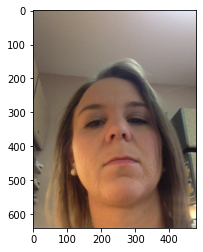

In [11]:
idx = np.random.randint(len(files))
meta = json.load(open(glob(files[idx].replace('images', 'meta')+"*.json")[0]))
print("device: ", meta['device'])
print("id: ", idx)
print("Num files: ", len(glob(files[idx]+"*.jpg")))
print("Sample:")
plt.imshow(plt.imread(glob(files[idx]+"*.jpg")[0]))

In [9]:
preds, gt = [], []
ctr = 1
f = files[idx]
# f = root+'/dataset/train/images/'
fs = glob(f+"*.jpg")
test_dataset = gazetrack_dataset(f, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=256, num_workers=10, pin_memory=False, shuffle=False,)

for j in tqdm(test_dataloader):
    leye, reye, kps, target = j[1], j[2], j[3], j[4]
    
    with torch.no_grad():
        pred = model(leye, reye, kps)
    pred = pred.detach().numpy()
    preds.extend(pred)  
    
    gt.extend(target.detach().numpy())
    
preds = np.array(preds)
pts = np.unique(gt, axis=0)

c = get_colors(len(pts))
random.shuffle(c)

gt = np.array(gt)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

Mean Euclidean Distance:  2.279752


(-13.0, 0.2)

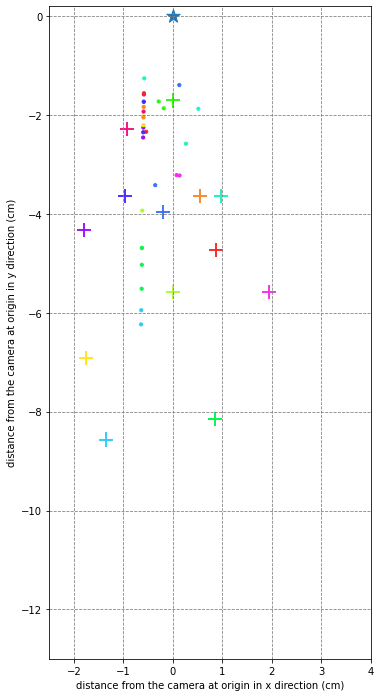

In [10]:
cols = np.zeros((len(gt),3))
for i in range(len(pts)):
    cols[np.where(np.all(gt==pts[i],axis=1))] = c[i]
    
plt.figure(figsize=(12,12))
plt.grid(color='gray', linestyle='dashed')
plt.scatter(0, 0, marker='*', s=200)
plt.scatter(preds[:,0], preds[:,1], c=cols, s=10)
plt.scatter(gt[:,0], gt[:,1], c=cols, marker='+', s=200)
plt.xlabel('distance from the camera at origin in x direction (cm)')
plt.ylabel('distance from the camera at origin in y direction (cm)')
plt.axis('scaled')
plt.xlim(-2.5, 4)
plt.ylim(-13, 0.2)

In [ ]:
preds, gt = [], []
ctr = 1
f = root+'/gazetrack/test/images/'
test_dataset = gazetrack_dataset(f, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=512, num_workers=10, pin_memory=False, shuffle=False,)

for j in tqdm(test_dataloader):
    leye, reye, kps, target = j[1], j[2], j[3], j[4]
    
    with torch.no_grad():
        pred = model(leye, reye, kps)
    pred = pred.detach().numpy()
    preds.extend(pred)  
    
    gt.extend(target.detach().numpy())
    
preds = np.array(preds)
pts = np.unique(gt, axis=0)

c = get_colors(len(pts))
random.shuffle(c)

gt = np.array(gt)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())

  1%|          | 1/117 [00:05<09:51,  5.10s/it]

In [ ]:
cols = np.zeros((len(gt),3))
for i in range(len(pts)):
    cols[np.where(np.all(gt==pts[i],axis=1))] = c[i]
    
plt.figure(figsize=(12,12))
plt.grid(color='gray', linestyle='dashed')
plt.scatter(0, 0, marker='*', s=200)
plt.scatter(preds[:100,0], preds[:100,1], c=cols[:100], s=5)
plt.scatter(gt[:100,0], gt[:100,1], c=cols[:100], marker='+', s=5)
plt.xlabel('distance from the camera at origin in x direction (cm)')
plt.ylabel('distance from the camera at origin in y direction (cm)')
plt.axis('scaled')
plt.xlim(-2.5, 4)
plt.ylim(-13, 0.2)

## Total Test

In [5]:
total_test = {}
for idx in tqdm(range(len(files))):
    preds, gt = [], []
    ctr = 1
    f = files[idx]
    test_dataset = gazetrack_dataset(f, phase='test')
    test_dataloader = DataLoader(test_dataset, batch_size=30, num_workers=10, pin_memory=False, shuffle=False,)

    for j in test_dataloader:
        leye, reye, kps, target = j[1], j[2], j[3], j[4]

        with torch.no_grad():
            pred = model(leye, reye, kps)
        pred = pred.detach().numpy()
        preds.extend(pred)  

        gt.extend(target.detach().numpy())

    preds = np.array(preds)
    pts = np.unique(gt, axis=0)

    gt = np.array(gt)
    dist = euc(preds, gt)
    total_test[idx] = [dist, gt, preds, pts]

100%|██████████| 1233/1233 [18:28<00:00,  1.11it/s]


2.18321

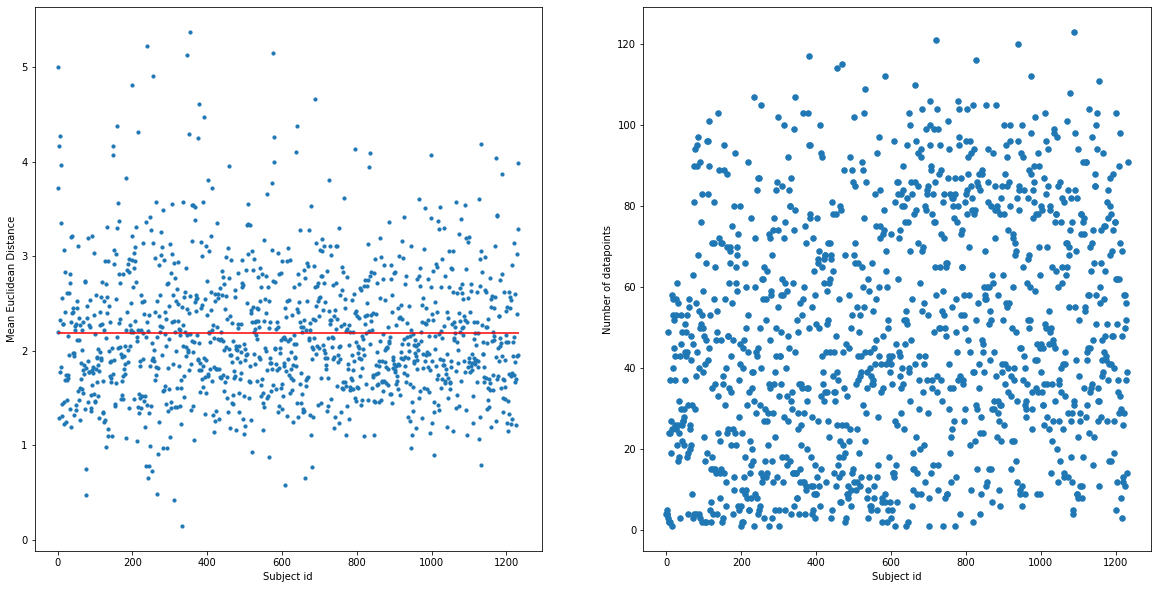

In [7]:
mean_errs = []
for i in total_test:
    mean_errs.append(np.mean(total_test[i][0]))
    
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter([i for i in range(len(mean_errs))], mean_errs, s=10)
plt.hlines(y=np.mean(mean_errs), xmin=0, xmax=len(mean_errs), color='r')
plt.xlabel('Subject id')
plt.ylabel('Mean Euclidean Distance')
plt.subplot(1,2,2)
plt.scatter([i for i in range(len(mean_errs))], [len(total_test[i][0]) for i in total_test], s=30)
plt.xlabel('Subject id')
plt.ylabel('Number of datapoints')
np.mean(mean_errs)

In [ ]:
np.std(mean_errs)/np.sqrt(len(mean_errs))

In [ ]:
dists = [total_test[i][0] for i in total_test]
plt.figure(figsize=(24,12))
plt.boxplot(dists)
plt.xlabel('Subject id')
plt.ylabel('Euc Distance')
a=1

In [ ]:
mean_errs = []
for i in total_test:
    mean_errs.extend(total_test[i][0])
plt.figure(figsize=(24, 12))
plt.scatter([i for i in range(len(mean_errs))], mean_errs, s=10)
plt.hlines(y=np.mean(mean_errs), xmin=0, xmax=len(mean_errs), color='r')
plt.xlabel('Test point id')
plt.ylabel('Mean Euclidean Distance')
np.mean(mean_errs)

In [ ]:
pts = np.unique(gt, axis=0)
cols = np.zeros((len(gt),3))
for i in range(len(pts)):
    cols[np.where(np.all(gt==pts[i],axis=1))] = c[i]
    
plt.figure(figsize=(12,12))
plt.grid(color='gray', linestyle='dashed')
plt.scatter(0, 0, marker='*', s=200)
plt.scatter(preds[:,0], preds[:,1], c=cols, s=10)
plt.scatter(gt[:,0], gt[:,1], c=cols, marker='+', s=200)
plt.xlabel('distance from the camera at origin in x direction (cm)')
plt.ylabel('distance from the camera at origin in y direction (cm)')
plt.axis('scaled')
plt.xlim(-2.5, 4)
plt.ylim(-13, 0.2)